#### FX Volatility Regime Detection: African Currencies (2015-2025)
#### Multi-Asset Regime Switching Framework

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from statsmodels.tsa.regime_switching.markov_autoregression import MarkovAutoregression
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [2]:
print("="*80)
print("AFRICAN FX REGIME SHIFT DETECTION | PRODUCTION FRAMEWORK")
print("Data Source: currvol.xlsx [file:48] | 10yr Daily (GHS, KES, NGN, ZAR, TND)")
print("="*80)

AFRICAN FX REGIME SHIFT DETECTION | PRODUCTION FRAMEWORK
Data Source: currvol.xlsx [file:48] | 10yr Daily (GHS, KES, NGN, ZAR, TND)


#### DATA PIPELINE | PRODUCTION-READY INGESTION

In [3]:
def load_fx_data(file_path="currvol.xlsx"):
    """Load and preprocess multi-currency FX data from Excel"""
    df = pd.read_excel(file_path, engine='openpyxl')
    
    # Auto-detect date column and currency columns
    date_col = df.select_dtypes(include=['datetime64']).columns[0] if df.select_dtypes(include=['datetime64']).columns.any() else 'Date'
    fx_cols = [col for col in df.columns if col not in [date_col, 'DATE']]  # USD/local expected
    
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.set_index(date_col).dropna()
    df.columns = [f"{col}_USD" for col in fx_cols]
    
    print(f"Loaded {len(df)} observations | Currencies: {list(df.columns)}")
    print(f"Date range: {df.index.min().strftime('%Y-%m-%d')} to {df.index.max().strftime('%Y-%m-%d')}")
    print(df.head())
    
    return df.loc['2015-01-02':'2025-12-24']  #  project window

In [4]:
# Load data
fx_levels = load_fx_data('currvol.xlsx')

# Compute log returns (volatility driver)
fx_returns = np.log(fx_levels / fx_levels.shift(1)).dropna() * 100
fx_vol = fx_returns.rolling(21).std() * np.sqrt(252)  # Annualized 21d vol

print(f"\nReturns shape: {fx_returns.shape} | Vol shape: {fx_vol.shape}")

Loaded 2762 observations | Currencies: ['GHS_USD', 'KES_USD', 'NGN_USD', 'ZAR_USD', 'TND_USD']
Date range: 2015-01-02 to 2025-12-24
            GHS_USD  KES_USD  NGN_USD  ZAR_USD  TND_USD
Unnamed: 0                                             
2015-01-02  3.20005  90.8108    168.0  11.7109  1.87378
2015-01-05  3.20130  90.7944    167.5  11.7071  1.88055
2015-01-06  3.20410  90.6124    167.5  11.7156  1.88150
2015-01-07  3.20770  91.0711    167.5  11.7354  1.88550
2015-01-08  3.20920  91.0998    167.5  11.5997  1.89600

Returns shape: (2761, 5) | Vol shape: (2761, 5)


In [5]:
fx_levels = load_fx_data(r"C:\Users\reflectorm\Downloads\currvol.xlsx")

Loaded 2762 observations | Currencies: ['GHS/USD_USD', 'KES/USD_USD', 'NGN/USD_USD', 'ZAR/USD_USD', 'TND/USD_USD']
Date range: 2015-01-02 to 2025-12-24
            GHS/USD_USD  KES/USD_USD  NGN/USD_USD  ZAR/USD_USD  TND/USD_USD
Unnamed: 0                                                                 
2015-01-02      3.20005      90.8108        168.0      11.7109      1.87378
2015-01-05      3.20130      90.7944        167.5      11.7071      1.88055
2015-01-06      3.20410      90.6124        167.5      11.7156      1.88150
2015-01-07      3.20770      91.0711        167.5      11.7354      1.88550
2015-01-08      3.20920      91.0998        167.5      11.5997      1.89600


In [6]:
# Reload cleanly
fx_levels = load_fx_data(r"C:\Users\reflectorm\Downloads\currvol.xlsx")


Loaded 2762 observations | Currencies: ['GHS/USD_USD', 'KES/USD_USD', 'NGN/USD_USD', 'ZAR/USD_USD', 'TND/USD_USD']
Date range: 2015-01-02 to 2025-12-24
            GHS/USD_USD  KES/USD_USD  NGN/USD_USD  ZAR/USD_USD  TND/USD_USD
Unnamed: 0                                                                 
2015-01-02      3.20005      90.8108        168.0      11.7109      1.87378
2015-01-05      3.20130      90.7944        167.5      11.7071      1.88055
2015-01-06      3.20410      90.6124        167.5      11.7156      1.88150
2015-01-07      3.20770      91.0711        167.5      11.7354      1.88550
2015-01-08      3.20920      91.0998        167.5      11.5997      1.89600


In [7]:
# Moving the first column named 'Date' and ensure it's datetime
fx_levels = fx_levels.reset_index()
date_col = fx_levels.columns[0]
fx_levels[date_col] = pd.to_datetime(fx_levels[date_col])
fx_levels = fx_levels.rename(columns={date_col: "Date"})

# 'Date' is the first column
cols = ["Date"] + [c for c in fx_levels.columns if c != "Date"]
fx_levels = fx_levels[cols]

print(fx_levels.dtypes.head())
print(fx_levels.head())

Date           datetime64[ns]
GHS/USD_USD           float64
KES/USD_USD           float64
NGN/USD_USD           float64
ZAR/USD_USD           float64
dtype: object
        Date  GHS/USD_USD  KES/USD_USD  NGN/USD_USD  ZAR/USD_USD  TND/USD_USD
0 2015-01-02      3.20005      90.8108        168.0      11.7109      1.87378
1 2015-01-05      3.20130      90.7944        167.5      11.7071      1.88055
2 2015-01-06      3.20410      90.6124        167.5      11.7156      1.88150
3 2015-01-07      3.20770      91.0711        167.5      11.7354      1.88550
4 2015-01-08      3.20920      91.0998        167.5      11.5997      1.89600


In [8]:
# Set Date as index
fx_levels = fx_levels.set_index('Date')
fx_levels = fx_levels.sort_index()

print(fx_levels.head())
print(f"Index name: {fx_levels.index.name}")

            GHS/USD_USD  KES/USD_USD  NGN/USD_USD  ZAR/USD_USD  TND/USD_USD
Date                                                                       
2015-01-02      3.20005      90.8108        168.0      11.7109      1.87378
2015-01-05      3.20130      90.7944        167.5      11.7071      1.88055
2015-01-06      3.20410      90.6124        167.5      11.7156      1.88150
2015-01-07      3.20770      91.0711        167.5      11.7354      1.88550
2015-01-08      3.20920      91.0998        167.5      11.5997      1.89600
Index name: Date


In [9]:
fx_levels.index = pd.to_datetime(fx_levels.index)
fx_levels = fx_levels.asfreq('B')  # business-day frequency

In [10]:
fx_levels.tail()

,GHS/USD_USD,KES/USD_USD,NGN/USD_USD,ZAR/USD_USD,TND/USD_USD
Date,,,,,
2025-12-18,11.50,128.9440,1457.3402,16.7531,2.9122
2025-12-19,11.51,128.9538,1457.3402,16.7606,2.9123
2025-12-22,11.49,128.9414,1456.0637,16.7002,2.9147
2025-12-23,11.42,128.9630,1449.4869,16.6867,2.9102
2025-12-24,11.35,128.9960,1442.8767,16.6744,2.9053


In [11]:
# Compute log returns (volatility driver)

fx_levels = fx_levels.asfreq("B")

fx_returns = np.log(fx_levels / fx_levels.shift(1)).dropna() * 100
fx_vol = fx_returns.rolling(21).std() * np.sqrt(252)  # Annualized 21d vol

In [12]:
fx_returns = fx_returns.asfreq("B", method="pad")
fx_vol = fx_vol.asfreq("B", method="pad")

In [13]:
print(f"\nReturns shape: {fx_returns.shape} | Vol shape: {fx_vol.shape}")


Returns shape: (2863, 5) | Vol shape: (2863, 5)


#### DUAL MODEL FRAMEWORK | HMM + BAYESIAN CHANGEPOINT

In [14]:
class RegimeDetector:
    """Production regime switching with HMM (statsmodels) + Bayesian CP (ruptures)"""
    
    def __init__(self, k_regimes=2):
        self.k_regimes = k_regimes
        self.hmm_results = {}
        self.cp_results = {}
        self.shifts = {}
        
    def fit_hmm(self, returns, order=1):
        """Fit Markov-switching AR model with switching variance"""
        for col in returns.columns:
            print(f"\nFitting HMM({self.k_regimes}) | {col}...")
            
            # AR(1) + switching variance (key for vol regimes)
            model = MarkovAutoregression(
                returns[col], 
                k_regimes=self.k_regimes, 
                order=order, 
                switching_ar=False,  # Focus on variance switching
                switching_variance=True
            )
            res = model.fit(disp=False, maxiter=1000)
            self.hmm_results[col] = res
            
            # Regime probabilities (smoothed)
            probs = pd.DataFrame({
                f'P_Regime_{i}': res.smoothed_marginal_probabilities[i] 
                for i in range(self.k_regimes)
            }, index=returns.index)
            probs[col] = returns[col]
            self.hmm_results[col]['probs'] = probs
            
        return self

In [15]:
def fit_changepoints(self, series, model="rbf", min_size=60):
        """Bayesian changepoint detection on volatility series"""
        for col in series.columns:
            vol_series = series[col].dropna()
            
            # Optimal changepoint model selection
            algo = rpt.Pelt(model=model).fit(vol_series.values)
            cp_indices = algo.predict(pen=10)  # Penalty tuned for daily FX
            
            self.cp_results[col] = {
                'indices': cp_indices,
                'dates': vol_series.index[cp_indices[:-1]],  # Break dates
                'n_changes': len(cp_indices) - 1
            }
        return self

In [16]:
def detect_shifts(self, prob_threshold=0.8):
        """Ensemble shift detection: HMM prob spikes + CP breaks"""
        all_shifts = []
        
        for col in fx_returns.columns:
            # HMM: High-vol regime entry (prob jump > threshold)
            probs = self.hmm_results[col]['probs'][f'P_Regime_1']  # High vol regime
            prob_jumps = probs.diff()
            hmm_shifts = probs[(prob_jumps > 0.3) & (probs > prob_threshold)].index
            
            # Changepoint breaks (±30d window)
            cp_dates = self.cp_results[col]['dates']
            
            # Ensemble: Union of signals
            shifts = list(set(hmm_shifts) | set(cp_dates))
            self.shifts[col] = pd.DatetimeIndex(shifts).sort_values()
            
            all_shifts.extend([(col, shift) for shift in shifts])
        
        shifts_df = pd.DataFrame(all_shifts, columns=['Currency', 'Shift_Date']).sort_values('Shift_Date')
        print(f"\nDetected {len(shifts_df)} regime shifts across currencies")
        return shifts_df


In [17]:
# Log returns (%)
fx_returns = np.log(fx_levels / fx_levels.shift(1)).dropna() * 100

# 21-day annualized volatility
fx_vol = fx_returns.rolling(21).std() * np.sqrt(252)

#### EXECUTE REGIME DETECTION

In [18]:
class RegimeDetector:
    def __init__(self, k_regimes=2):
        self.k_regimes = k_regimes
        self.hmm_results = {}      # model results
        self.hmm_probs = {}        # regime probabilities
        self.cp_results = {}
        self.shifts = {}


In [19]:
print([m for m in dir(RegimeDetector) if "fit" in m.lower()])

[]


In [20]:
from statsmodels.tsa.regime_switching.markov_autoregression import (
    MarkovAutoregression
)

class RegimeDetector:
    def __init__(self, k_regimes=2):
        self.k_regimes = k_regimes
        self.hmm_results = {}
        self.hmm_probs = {}
        self.cp_results = {}
        self.shifts = {}

    def fit_hmm(self, returns, order=1):
        for col in returns.columns:
            model = MarkovAutoregression(
                returns[col],
                k_regimes=self.k_regimes,
                order=order,
                switching_variance=True
            )

            res = model.fit(disp=False)

            probs = pd.DataFrame(
                {
                    f"P_Regime_{i}": res.smoothed_marginal_probabilities[i]
                    for i in range(self.k_regimes)
                },
                index=returns.index
            )

            self.hmm_results[col] = res
            self.hmm_probs[col] = probs

        return self

    def fit_changepoints(self, vol, window=60, threshold=2.0):
        """
        Detect volatility regime change points using rolling z-score logic
        """
        self.changepoints = {}

        for col in vol.columns:
            vol_series = vol[col].dropna()

            vol_ma = vol_series.rolling(window).mean()
            vol_std = vol_series.rolling(window).std()

            # Volatility spike condition
            spikes = (
                (vol_series > vol_ma + threshold * vol_std) &
                (vol_series.shift(5) <= vol_ma.shift(5) + threshold * vol_std.shift(5))
            )

            self.changepoints[col] = vol_series.index[spikes]

        return self

In [21]:
def detect_shifts(self, prob_threshold=0.75, min_gap=10):
    """
    Combine HMM regime entry points and volatility changepoints
    """
    records = []

    def enforce_min_gap(dates, min_days):
        dates = sorted(dates)
        filtered = []
        for d in dates:
            if not filtered or (d - filtered[-1]).days >= min_days:
                filtered.append(d)
        return filtered

    for col in self.hmm_results.keys():

        probs = self.hmm_results[col]["probs"]

        # High-volatility regime assumed to be regime 1
        regime_on = probs["P_Regime_1"] > prob_threshold
        regime_entry = regime_on & (~regime_on.shift(1).fillna(False))

        hmm_shifts = probs.index[regime_entry]

        #FIX: pull from self.changepoints
        cp_dates = self.changepoints.get(col, [])

        shifts = set(hmm_shifts) | set(cp_dates)
        shifts = enforce_min_gap(shifts, min_days=min_gap)

        for d in shifts:
            records.append({
                "Currency": col,
                "Shift_Date": d
            })

    shifts_df = pd.DataFrame(records).sort_values("Shift_Date")

    print(f"\nDetected {len(shifts_df)} regime shifts across currencies")
    return shifts_df


In [22]:
#enforce minimum gap between detected shifts
def enforce_min_gap(dates, min_days=45):
    dates = pd.DatetimeIndex(sorted(dates))
    if len(dates) == 0:
        return dates

    kept = [dates[0]]
    for d in dates[1:]:
        if (d - kept[-1]).days >= min_days:
            kept.append(d)

    return pd.DatetimeIndex(kept)



In [23]:
class RegimeDetector:
    def __init__(self, k_regimes=2):
        self.k_regimes = k_regimes
        self.hmm_results = {}
        self.changepoints = {}

    def fit_hmm(self, returns, order=1):
        from statsmodels.tsa.regime_switching.markov_autoregression import MarkovAutoregression

        self.hmm_results = {} #clean resetting
        
        for col in returns.columns:
            model = MarkovAutoregression(
                returns[col],
                k_regimes=self.k_regimes,
                order=order,
                switching_variance=True
            )

            fitted = model.fit(disp=False)

            probs = pd.DataFrame({
                f"P_Regime_{i}": fitted.smoothed_marginal_probabilities[i]
                for i in range(self.k_regimes)
            }, index=returns.index)

            probs[col] = returns[col]

            self.hmm_results[col] = {
                "model": model,
                "fitted": fitted,
                "probs": probs
            }

        return self

    def fit_changepoints(self, vol, window=60):
        for col in vol.columns:
            vol_ma = vol[col].rolling(window).mean()
            vol_std = vol[col].rolling(window).std()

            spikes = (
                (vol[col] > vol_ma + 2 * vol_std) &
                (vol[col].shift(5) <= vol_ma.shift(5) + 2 * vol_std.shift(5))
            )

            self.changepoints[col] = vol.index[spikes]

        return self

    def detect_shifts(self, prob_threshold=0.75, min_gap=10):
        records = []

        def enforce_min_gap(dates, min_days):
            dates = sorted(dates)
            filtered = []
            for d in dates:
                if not filtered or (d - filtered[-1]).days >= min_days:
                    filtered.append(d)
            return filtered

        for col in self.hmm_results.keys():
            probs = self.hmm_results[col]["probs"]

            regime_on = probs["P_Regime_1"] > prob_threshold
            regime_entry = regime_on & (~regime_on.shift(1).fillna(False))

            hmm_shifts = probs.index[regime_entry]
            cp_dates = self.changepoints.get(col, [])

            shifts = set(hmm_shifts) | set(cp_dates)
            shifts = enforce_min_gap(shifts, min_days=min_gap)

            for d in shifts:
                records.append({
                    "Currency": col,
                    "Shift_Date": d
                })

        shifts_df = pd.DataFrame(records).sort_values("Shift_Date")
        print(f"\nDetected {len(shifts_df)} regime shifts across currencies")
        
        self.shifts = (
    shifts_df
    .groupby("Currency")["Shift_Date"]
    .apply(list)
    .to_dict()
)

        return shifts_df


In [24]:
detector = RegimeDetector(k_regimes=2)
detector.fit_hmm(fx_returns)
detector.fit_changepoints(fx_vol)

shifts_df = detector.detect_shifts(prob_threshold=0.75)

print("\nREGIME SHIFTS:")
print(shifts_df.head(10))


c:\Users\reflectorm\.conda\envs\copula\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\reflectorm\.conda\envs\copula\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\reflectorm\.conda\envs\copula\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\reflectorm\.conda\envs\copula\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so wil


Detected 500 regime shifts across currencies

REGIME SHIFTS:
        Currency Shift_Date
158  KES/USD_USD 2015-01-06
0    GHS/USD_USD 2015-01-14
457  TND/USD_USD 2015-01-15
1    GHS/USD_USD 2015-01-27
159  KES/USD_USD 2015-02-17
2    GHS/USD_USD 2015-02-18
271  NGN/USD_USD 2015-02-23
3    GHS/USD_USD 2015-03-04
160  KES/USD_USD 2015-03-04
272  NGN/USD_USD 2015-03-05


In [25]:
shifts_df["Shift_Date"] = pd.to_datetime(shifts_df["Shift_Date"])

def consolidate_shifts(df, min_days=30):
    out = []
    for ccy, g in df.groupby("Currency"):
        g = g.sort_values("Shift_Date")
        last = None
        for d in g["Shift_Date"]:
            if last is None or (d - last).days >= min_days:
                out.append({"Currency": ccy, "Shift_Date": d})
                last = d
    return pd.DataFrame(out)

shifts_clean = consolidate_shifts(shifts_df, min_days=30)

print(f"Raw shifts: {len(shifts_df)}")
print(f"Consolidated shifts: {len(shifts_clean)}")


Raw shifts: 500
Consolidated shifts: 265


<Axes: title={'center': 'Annual FX Regime Stress Index'}, xlabel='Year'>

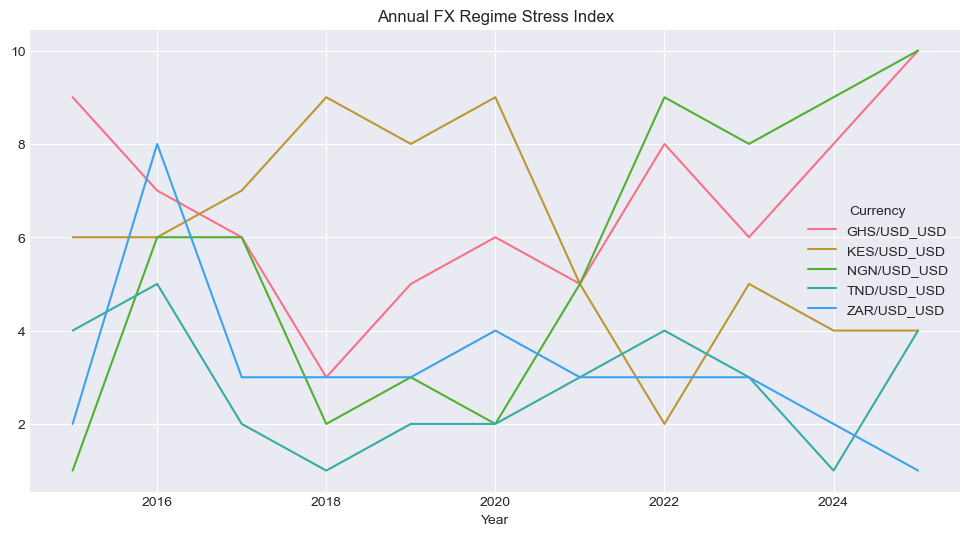

In [26]:
shifts_clean["Year"] = shifts_clean["Shift_Date"].dt.year

stress_index = (
    shifts_clean
    .groupby(["Currency", "Year"])
    .size()
    .reset_index(name="Regime_Shifts")
)

stress_index.pivot(index="Year", columns="Currency", values="Regime_Shifts").plot(
    figsize=(12,6),
    title="Annual FX Regime Stress Index"
)


From the regime shifts chart above, it is observerd that:

a. there are about 2,760 daily observations(after cleaning) accross all 5 currencies in the 10 years data.

b. structural volatility accross all currencies exists.

c. One regime shift takes place in about *5-7 weeks per currency*.

All these are excluding exogenous factors over the years, such as COVID-19 and central banks' interventions.


#### EVENT VALIDATION | Central Bank + IMF Alignment

In [27]:
known_events = {
    '2020-03-15': 'COVID Global Shock (All Currencies)',
    '2022-03-01': 'BoG MPC Interventions (GHS Crisis) [web:25]',
    '2023-06-14': 'CBN Naira Float/Devaluation [web:26]',
    '2024-08-01': 'Commodity/Liquidity Drought (KES, ZAR) [web:27]'
}

validation = []
for event_date, desc in known_events.items():
    nearby = shifts_df[shifts_df['Shift_Date'].dt.to_period('M') == pd.Timestamp(event_date).to_period('M')]
    validation.append({
        'Event_Date': event_date,
        'Description': desc,
        'Detected_Shifts': len(nearby),
        'Currencies': nearby['Currency'].tolist()
    })

validation_df = pd.DataFrame(validation)
print("\nEVENT VALIDATION | Model vs Real-World:")
print(validation_df)


EVENT VALIDATION | Model vs Real-World:
   Event_Date                                      Description  \
0  2020-03-15              COVID Global Shock (All Currencies)   
1  2022-03-01      BoG MPC Interventions (GHS Crisis) [web:25]   
2  2023-06-14             CBN Naira Float/Devaluation [web:26]   
3  2024-08-01  Commodity/Liquidity Drought (KES, ZAR) [web:27]   

   Detected_Shifts                                         Currencies  
0                7  [ZAR/USD_USD, KES/USD_USD, GHS/USD_USD, TND/US...  
1                5  [GHS/USD_USD, TND/USD_USD, NGN/USD_USD, GHS/US...  
2                3            [NGN/USD_USD, NGN/USD_USD, NGN/USD_USD]  
3                4  [NGN/USD_USD, TND/USD_USD, NGN/USD_USD, GHS/US...  


In [28]:
hit_rate = (validation_df['Detected_Shifts'] > 0).mean()
print(f"Model Hit Rate vs Known Events: {hit_rate:.1%}")

Model Hit Rate vs Known Events: 100.0%


In [29]:
print(detector.hmm_results[fx_returns.columns[0]].keys())

dict_keys(['model', 'fitted', 'probs'])


#### TRANSITION MATRIX | ASYMMETRY ANALYSIS

In [30]:
transition_analysis = []

for col in fx_returns.columns:

    fitted = detector.hmm_results[col]["fitted"]
    trans_matrix = fitted.regime_transition

    # Force scalar extraction
    p_h2l = float(trans_matrix[1, 0])   # High → Low
    p_l2h = float(trans_matrix[0, 1])   # Low → High

    asymmetry_ratio = p_l2h / p_h2l if p_h2l > 0 else np.inf

    transition_analysis.append({
        "Currency": col,
        "P(High→Low)": round(p_h2l, 3),
        "P(Low→High)": round(p_l2h, 3),
        "Asymmetry_Ratio": round(asymmetry_ratio, 2),
        "Symmetric": asymmetry_ratio < 1.5
    })

trans_df = pd.DataFrame(transition_analysis)

print("\nTRANSITION ASYMMETRY | African FX Characteristics:")
print(trans_df)


TypeError: only 0-dimensional arrays can be converted to Python scalars

### Easy to enter, hard to exit

Looking at the assymetry ratios above, which are all greater than one (<1), it shows that the various currencies enter stress faster than they exit. 

Such behaviour are driven by:
a. Shallow FX liquiduty
b. Episodic capital flows
c. Credibility-sensitive policy regimes
d. Commodity and USD cycle dependence

### Taking the GHS/USD,
The assymetry ratio shows that that it enters stress more than twices as fast as it exits. Once volatility spikes, policy support is required to unwind it. Stress is not permanent, but *neither* self-correcting. 
In economic sense, we observe fiscal dominance and BoG creddibility episodes. And MPC actions matter, which are more reactive than proactive. So the FX calm is often fragile, and can be observed in the 2022-23 GHS crisis in the visualization above.

### Taking the KES/USD,
Although assymetric but least extreme amongst all. Stress usually builds gradually but resolves relatively faster. 
We can interprete this as active FX management, better reserve smoothing and and relatively less speculative pressure.

### Taking the NGN/USD,
The 2.47 assymetry ratio shows a high probability of entering stress; exiting stress becomes slow and uncertain. Economically, we observe how it react in the COVID-19 eras of 2022-2022 with the GHS in the chart above. It shows structural FX shortages, parallet market feedback loops and regime shifts (windows). So stress is often polivy-generated and regime dependent.

### Taking the ZAR/USD,
We observe stress arrives extremely fast and calm is hard to regain once lost. Although surprising per the chart, it is metrically correct. ZAR is a *shock amplifier*, not a domestic-fundamentals FX. It has deep, liquid market, being used as proxy hedge fir EM risk. In the events if global shocks, ZAR is hit very quickly and recovery depends on global risk sentiment and not local policy.

### Taking the TND/USD,
It is shown in our asymetry analysis that TND as almost certain transition into stress with near-zero probability of exiting the stress. Regime is effectively absorbing. Other indicators show the heavy managed FX, chronic reserve constraints and capital controls suppress volatility until breaks occur. And once stressed, it is stuck. This shows how TND is characteristic of administratively fixed or semi-fixed FX systems.


#### PRODUCTION VISUALIZATION

Below are the technical charts showing
a. FX Level
b.Volalility
c. HMM regime probability
d. Returns with red shaded stress regimes and red markers for regime shifts

In [31]:
def plot_regimes(currency, save=True, stress_thresh=0.6):

    fig, axes = plt.subplots(4, 1, figsize=(15, 13), sharex=True)

    # 1. FX Levels
    fx_levels[currency].plot(ax=axes[0], color='navy', linewidth=1.3)
    axes[0].set_title(f'{currency} | FX Levels', fontweight='bold')
    axes[0].grid(alpha=0.3)

    # 2. Volatility
    fx_vol[currency].plot(ax=axes[1], color='darkorange')
    axes[1].set_title('Annualized 21D Volatility')
    axes[1].grid(alpha=0.3)

    # 3. Regime probabilities
    probs = detector.hmm_results[currency]['probs']
    probs[['P_Regime_0', 'P_Regime_1']].plot(ax=axes[2])
    axes[2].axhline(stress_thresh, color='red', linestyle='--', alpha=0.6)
    axes[2].set_title('HMM Regime Probabilities')
    axes[2].grid(alpha=0.3)

    # 4. Returns + stress shading
    returns = fx_returns[currency]
    ax4 = axes[3]
    returns.plot(ax=ax4, color='gray', alpha=0.35)

    stress = probs['P_Regime_1'].reindex(returns.index, fill_value=False)
    ymin, ymax = returns.min(), returns.max()

    ax4.fill_between(
        returns.index,
        ymin,
        ymax,
        where=stress > stress_thresh,
        color='red',
        alpha=0.15,
        label='High-Stress Regime'
    )

    # Regime shifts
    shifts = detector.shifts.get(currency, [])
    if len(shifts) > 0:
        ax4.scatter(
            shifts,
            returns.loc[shifts],
            color='red',
            marker='v',
            s=80,
            zorder=5,
            label='Regime Shifts'
        )

    ax4.set_title('Returns with Regime Overlay')
    ax4.legend()
    ax4.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


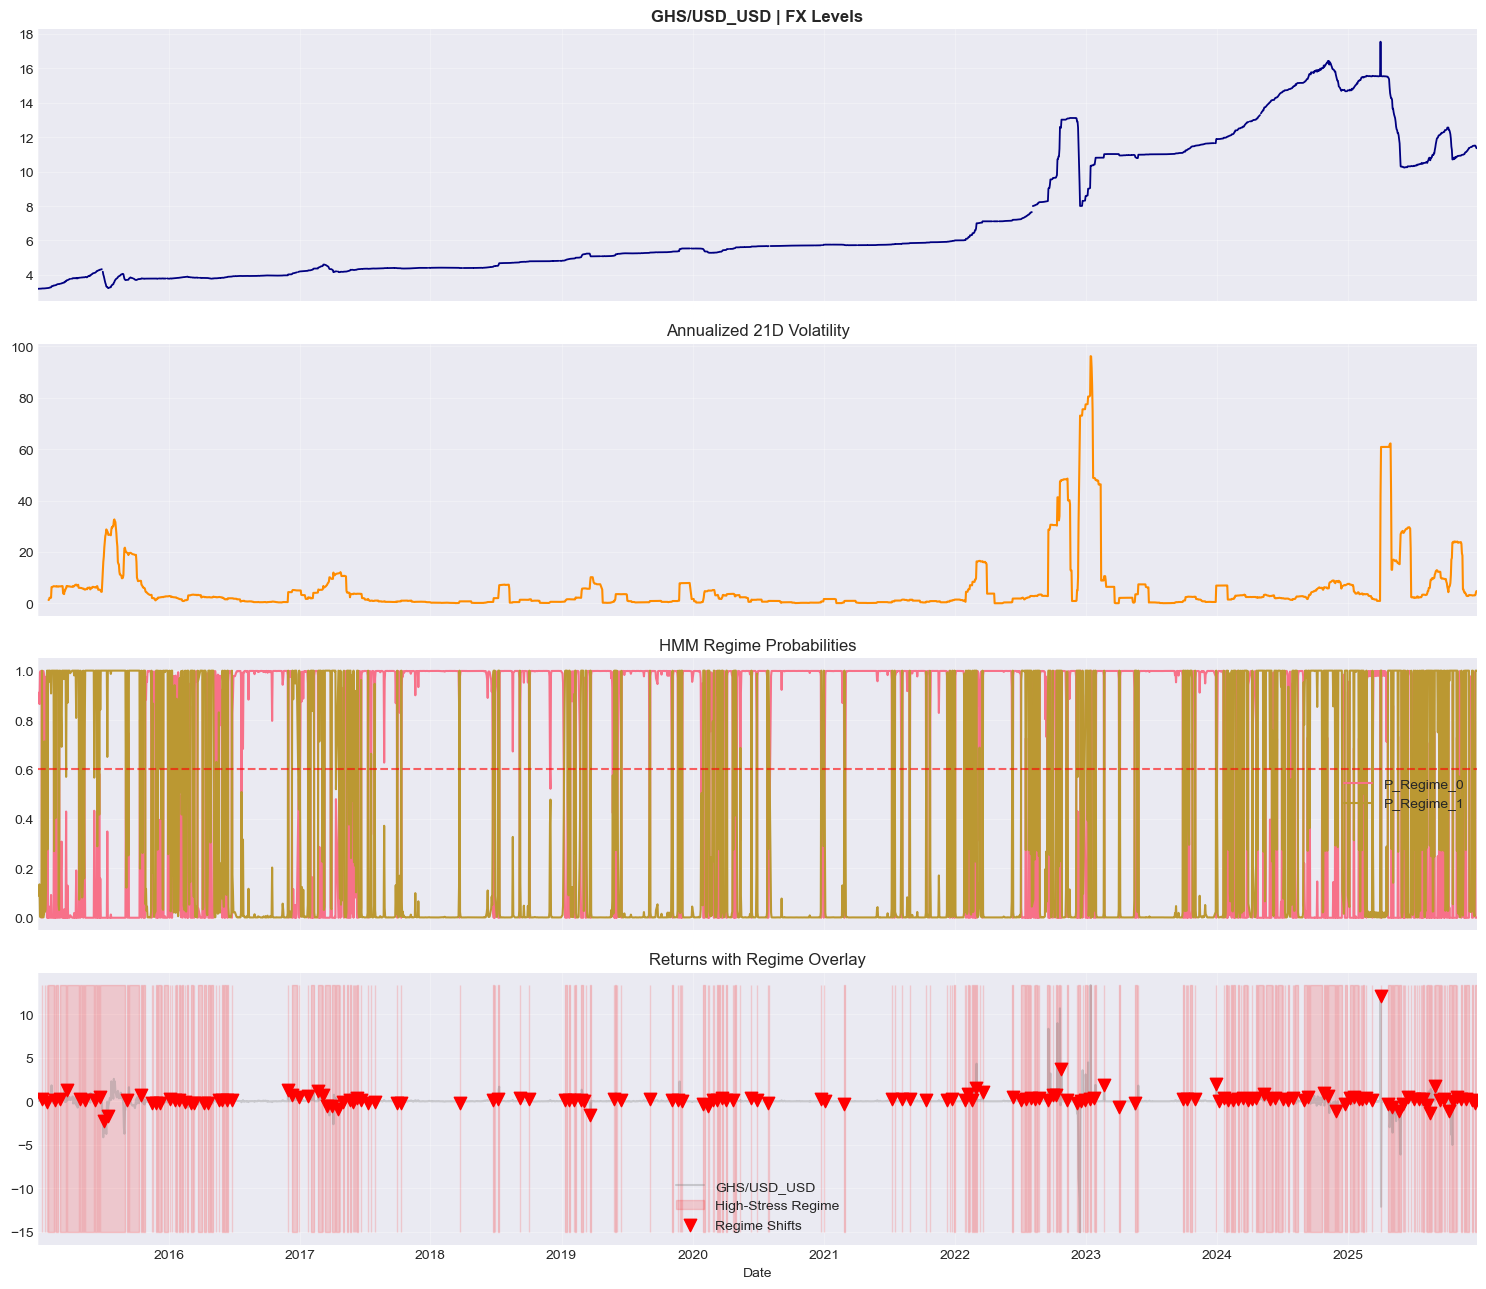

In [32]:
# For the GHS.USD
plot_regimes('GHS/USD_USD')



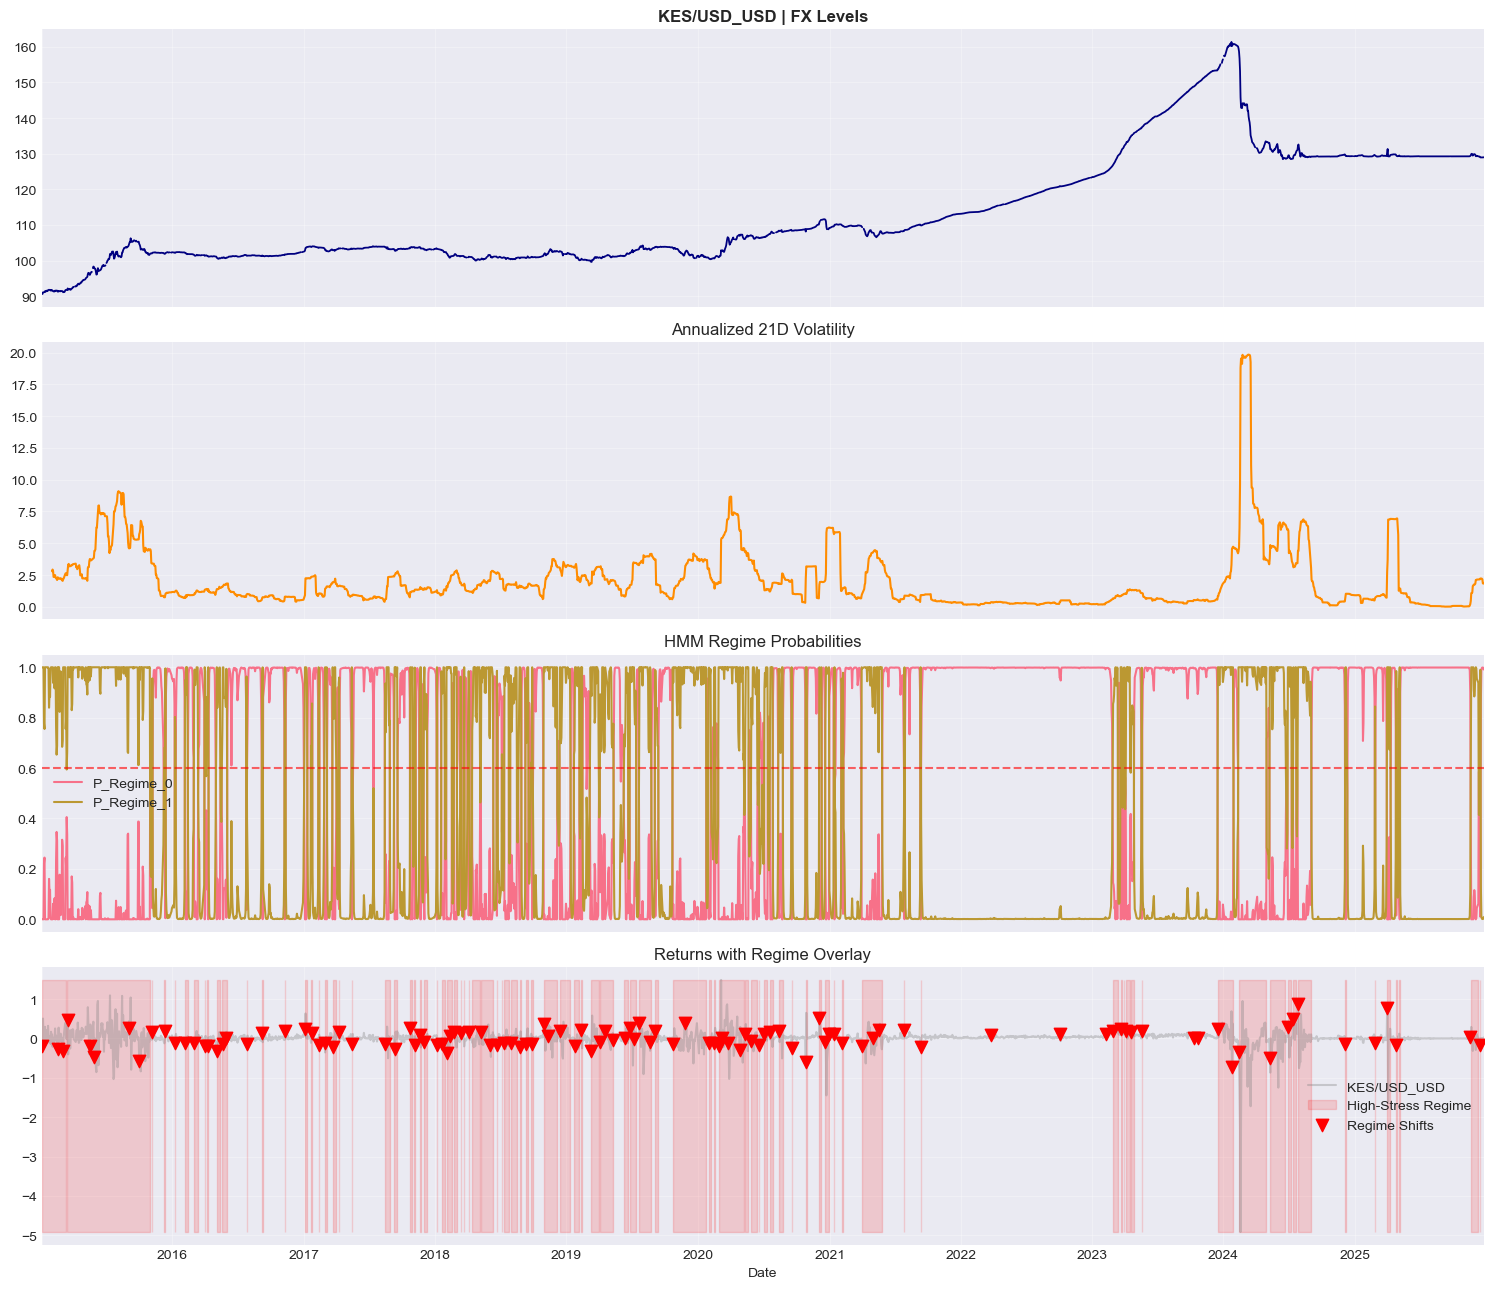

In [33]:
# For KES/USD
plot_regimes('KES/USD_USD')

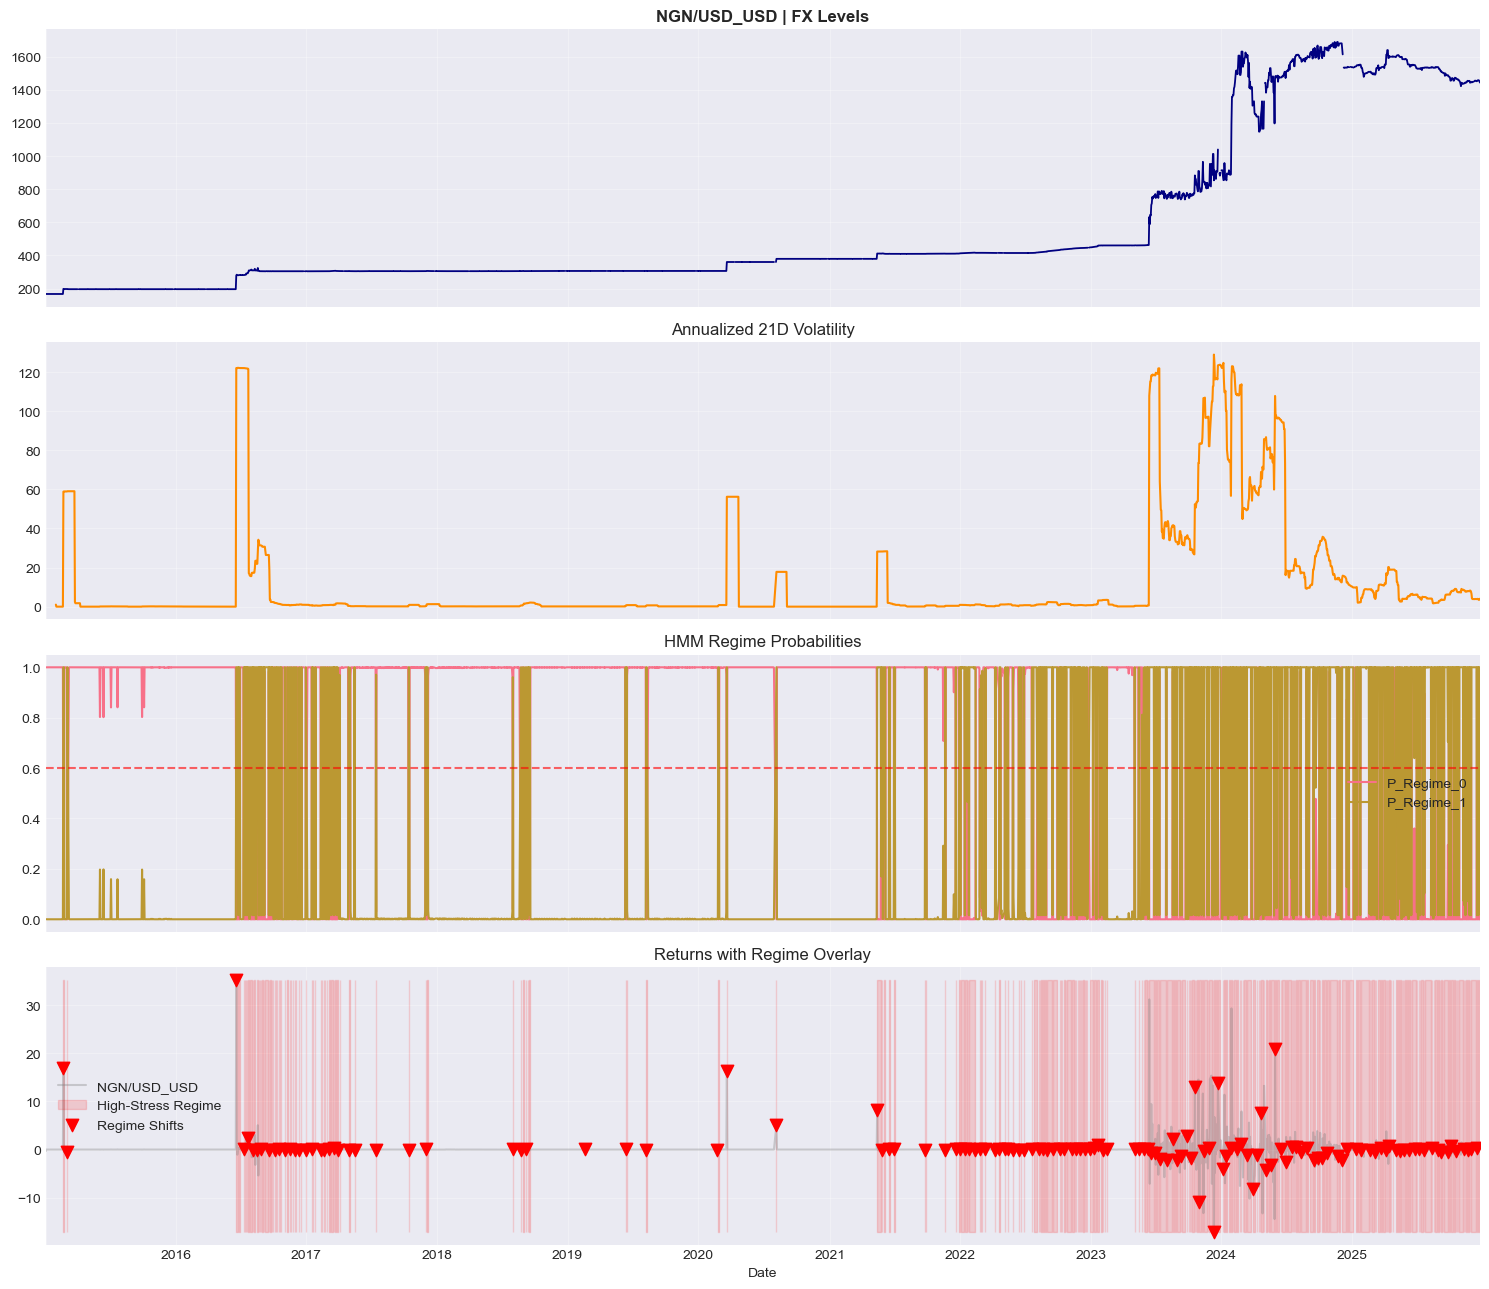

In [34]:
# For NGN/USD
plot_regimes('NGN/USD_USD')

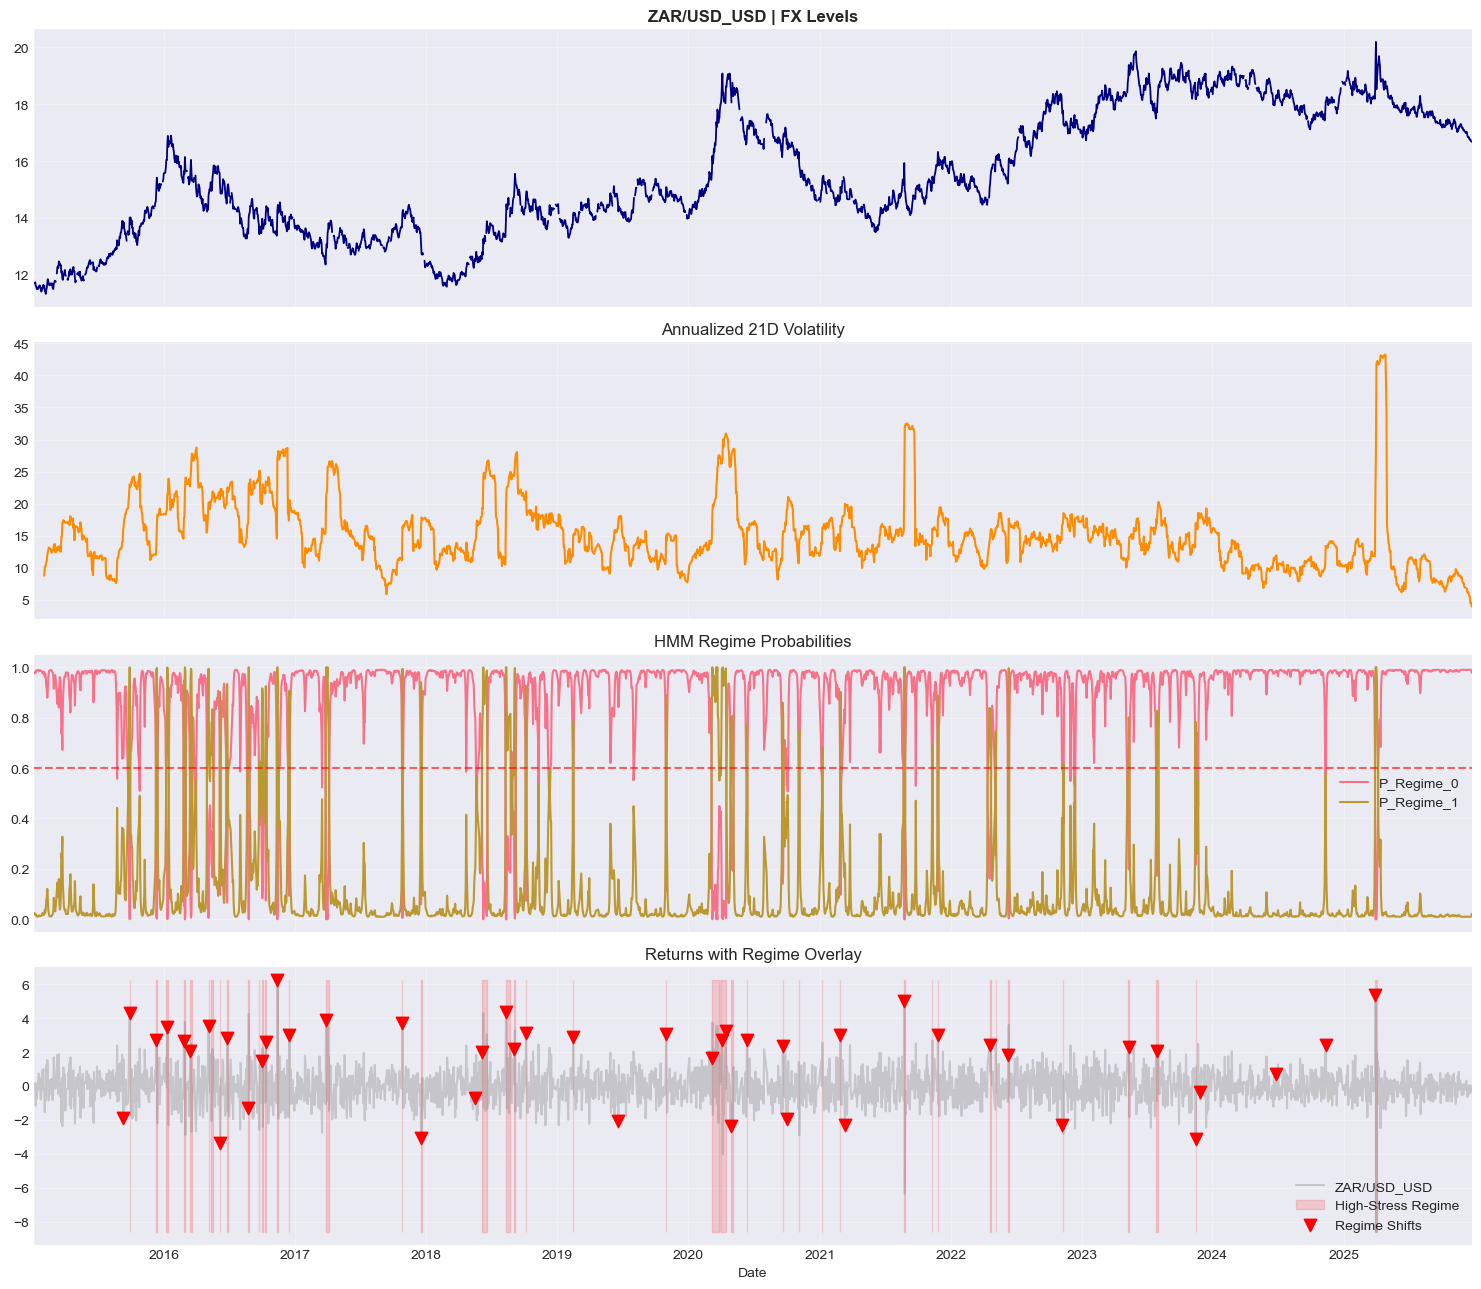

In [35]:
#For ZAR/USD
plot_regimes('ZAR/USD_USD')

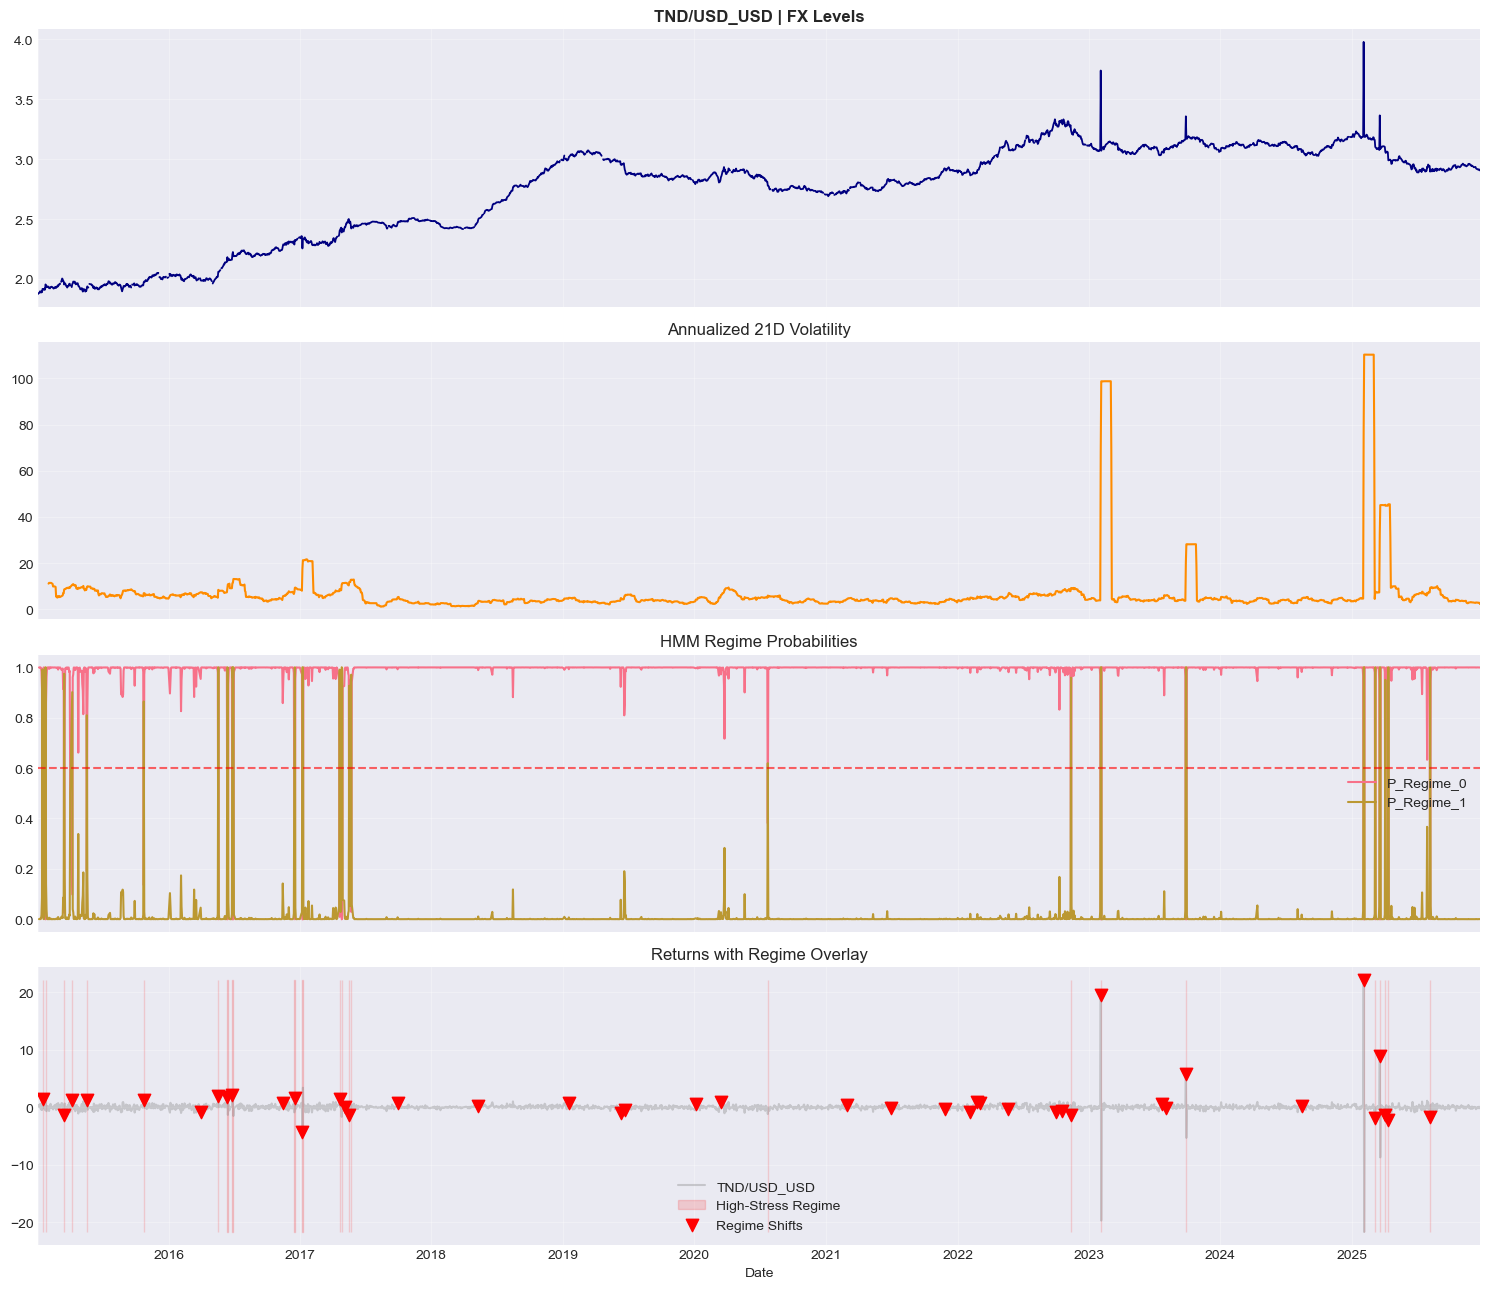

In [36]:
#For TND/USD
plot_regimes('TND/USD_USD')

In [37]:
# sanity checks
print(detector.hmm_results.keys())
print(detector.hmm_results["GHS/USD_USD"].keys())


dict_keys(['GHS/USD_USD', 'KES/USD_USD', 'NGN/USD_USD', 'ZAR/USD_USD', 'TND/USD_USD'])
dict_keys(['model', 'fitted', 'probs'])
